In [3]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.
/home/mercy/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mercy/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mercy/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mercy/.local/lib/python3.7/site-packages/tensorflow/python/fra

In [4]:
#filename = 'eng-swahili/swahili.txt'
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [5]:
#split the text into swahili-english pairs
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [6]:
data = read_text("eng-swahili/swahili.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [7]:
deu_eng = deu_eng[:50,:]

In [8]:
deu_eng

array([['Any recent chills, night sweats or fever?',
        'Kuumwa , kutokwa majasho usiku au joto lolote hivi majuzi?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Have you gained or lost weight without trying?',
        'Je, umeongeza au kupunguza uzani bila kukusudia?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Have you been tired?', 'Je, umewahi kuchoka?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ['Any dry or itchy areas?',
        'Maeneo yoyote yaliyokauka au yanayowasha?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)'],
       ['Any rashes, bumps, or sores anywhere?',
        'Vipele, majipu au vidonda popote?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #941078 (Fingerhut)'],
       ['Do you bruise easily?', 'Je, wewe huchib

In [9]:
#remove punctuations
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]


In [10]:
deu_eng

array([['Any recent chills night sweats or fever',
        'Kuumwa  kutokwa majasho usiku au joto lolote hivi majuzi',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Have you gained or lost weight without trying',
        'Je umeongeza au kupunguza uzani bila kukusudia',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Have you been tired', 'Je umewahi kuchoka',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ['Any dry or itchy areas',
        'Maeneo yoyote yaliyokauka au yanayowasha',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)'],
       ['Any rashes bumps or sores anywhere',
        'Vipele majipu au vidonda popote',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #941078 (Fingerhut)'],
       ['Do you bruise easily', 'Je wewe huchibuka kwa urahisi',
 

In [11]:
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()


In [12]:
deu_eng

array([['any recent chills night sweats or fever',
        'kuumwa  kutokwa majasho usiku au joto lolote hivi majuzi',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['have you gained or lost weight without trying',
        'je umeongeza au kupunguza uzani bila kukusudia',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['have you been tired', 'je umewahi kuchoka',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ['any dry or itchy areas',
        'maeneo yoyote yaliyokauka au yanayowasha',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)'],
       ['any rashes bumps or sores anywhere',
        'vipele majipu au vidonda popote',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #941078 (Fingerhut)'],
       ['do you bruise easily', 'je wewe huchibuka kwa urahisi',
 

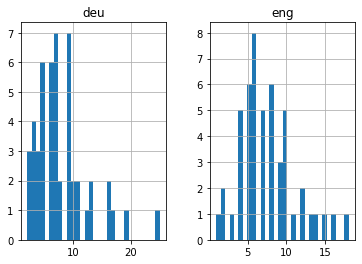

In [13]:
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [14]:
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [15]:
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 168


In [16]:
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 207


In [17]:
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [18]:
#build the model

In [19]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [20]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [21]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [78]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 80)

In [79]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [87]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=70, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Train on 32 samples, validate on 8 samples
Epoch 1/30
32/32 [==============================] - 1s 38ms/step - loss: 4.2609 - val_loss: 4.8433

Epoch 00001: val_loss improved from inf to 4.84335, saving model to model.h1.24_jan_19
Epoch 2/30
32/32 [==============================] - 0s 448us/step - loss: 4.1982 - val_loss: 4.8530

Epoch 00002: val_loss did not improve from 4.84335
Epoch 3/30
32/32 [==============================] - 0s 451us/step - loss: 4.1512 - val_loss: 4.8643

Epoch 00003: val_loss did not improve from 4.84335
Epoch 4/30
32/32 [==============================] - 0s 613us/step - loss: 4.1128 - val_loss: 4.8782

Epoch 00004: val_loss did not improve from 4.84335
Epoch 5/30
32/32 [==============================] - 0s 600us/step - loss: 4.0793 - val_loss: 4.8930

Epoch 00005: val_loss did not improve from 4.84335
Epoch 6/30
32/32 [==============================] - 0s 771us/step - loss: 4.0491 - val_loss: 4.9092

Epoch 00006: val_loss did not improve from 4.84335
Epoch 7/30

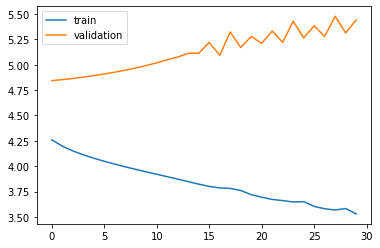

In [88]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [89]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [90]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [91]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [92]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [93]:
# print 15 rows randomly
pred_df.sample(10)

,actual,predicted
1,when was your last mammogram,
2,have you had any dizziness room spinning or lightheadedness,
6,any hoarseness,
8,any recent sore throat or sores in your mouth,
9,have you fainted or passed out,
3,any loss of hair from your legs or sores that don’t heal,
4,do you ever awake at night short of breath,
7,any nausea vomiting cramping diarrhea,
0,any pain when you take a deep breath,
5,any cough or phlegm production,
